In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE= 256
BATCH_SIZE= 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
'PotatoDisease',
shuffle= True,
image_size= (IMAGE_SIZE, IMAGE_SIZE),
batch_size= BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
# this is because every element in the dataset is a batch of 32 images
68*32 # 2176 is very close to 2152

2176

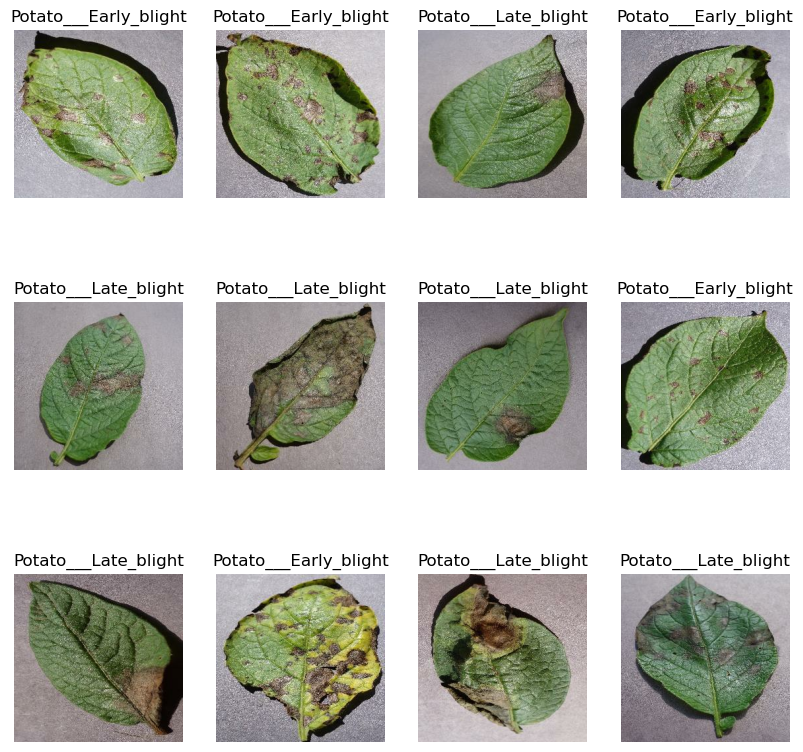

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
    #print(image_batch[0].shape)
    #print(label_batch.numpy()) 
    #print(image_batch[0].numpy())

In [8]:
len(dataset)

68

In [11]:
#80% ==> training
#20% ==> 10% validation, 10% test 

In [12]:
train_size= 0.8
len(dataset)*train_size

54.400000000000006

In [13]:
train_ds= dataset.take(54)
len(train_ds)

54

In [14]:
test_ds = dataset.skip(54)
len(test_ds) 

14

In [15]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [16]:
val_ds = test_ds.take(6)
len(val_ds) 

6

In [17]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10_000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed= 42)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

In [21]:
len(val_ds)

6

In [22]:
len(test_ds)

8

In [23]:
train_ds = train_ds.cache().shuffle(1_000).prefetch(buffer_size=tf.data.AUTOTUNE) 
val_ds = val_ds.cache().shuffle(1_000).prefetch(buffer_size=tf.data.AUTOTUNE) 
test_ds = test_ds.cache().shuffle(1_000).prefetch(buffer_size=tf.data.AUTOTUNE) 

In [24]:
#resize_and_rescale = tf.keras.Sequential([
    #layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    #layers.experimental.preprocessing.Rescaling(1.0/255)
#])

In [25]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

In [26]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
])

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(32, (3,3), input_shape= input_shape),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation= 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation= 'softmax'), #n_classes
])

model.build(input_shape= input_shape)

C:\Users\HP REVOLVE\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [28]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(
optimizer= 'adam',
loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics= ['accuracy'])

In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)

In [33]:
history = model.fit(
train_ds,
epochs=EPOCHS,
batch_size= BATCH_SIZE,
verbose=1,
validation_data= val_ds,
callbacks=[early_stopping]) 

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.4869 - loss: 0.9254 - val_accuracy: 0.6979 - val_loss: 0.7855
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.7072 - loss: 0.7081 - val_accuracy: 0.7656 - val_loss: 0.5075
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.7908 - loss: 0.4499 - val_accuracy: 0.9010 - val_loss: 0.2678
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8951 - loss: 0.2664 - val_accuracy: 0.8698 - val_loss: 0.3512
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8923 - loss: 0.2602 - val_accuracy: 0.8906 - val_loss: 0.3078
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9051 - loss: 0.2204 - val_accuracy: 0.8854 - val_loss: 0.2705
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9215 - loss: 0.1975 - val_accuracy: 0.8594 - val_loss: 0.3128
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9222 - loss: 0.2030 - val_accuracy: 0.9167 - val_loss

In [34]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 370ms/step - accuracy: 1.0000 - loss: 0.0068


In [38]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

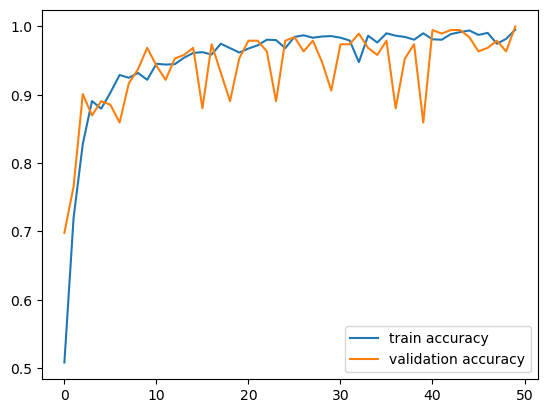

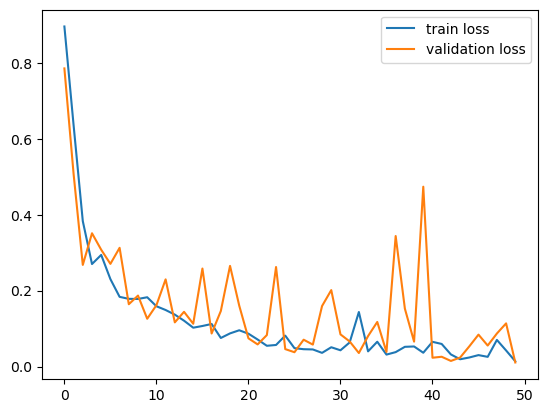

In [43]:
import numpy as np
import pandas as pd

history_df = pd.DataFrame(history.history)

# Plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [ ]:
#scores

In [ ]:
#acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

#loss = history.history['loss']
#val_loss = history.history['val_loss']

In [ ]:
#plt.figure(figsize=(8,8))
#plt.subplot(1,2,1)
#plt.plot(range(EPOCHS), acc, label= 'Training Accuracy')
#plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
#plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy') 

#plt.subplot(1,2,2)
#plt.plot(range(EPOCHS), loss, label='Training Loss')
#plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
#plt.legend(loc='upper right')
#plt.title('Training and Validation Loss')
#plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
predicted label: Potato___Late_blight


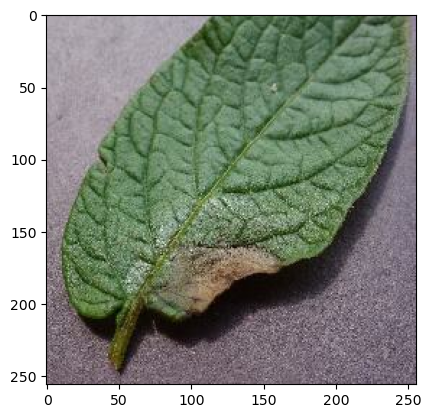

In [45]:
for images_batch, labels_batch in test_ds.take(1):
    
    #plt.imshow(images_batch[0].numpy().astype('uint8')) 
    #print(images_batch[0].numpy().astype('uint8'))
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print('actual label:', class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print('predicted label:', class_names[np.argmax(batch_prediction[0])])

In [46]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


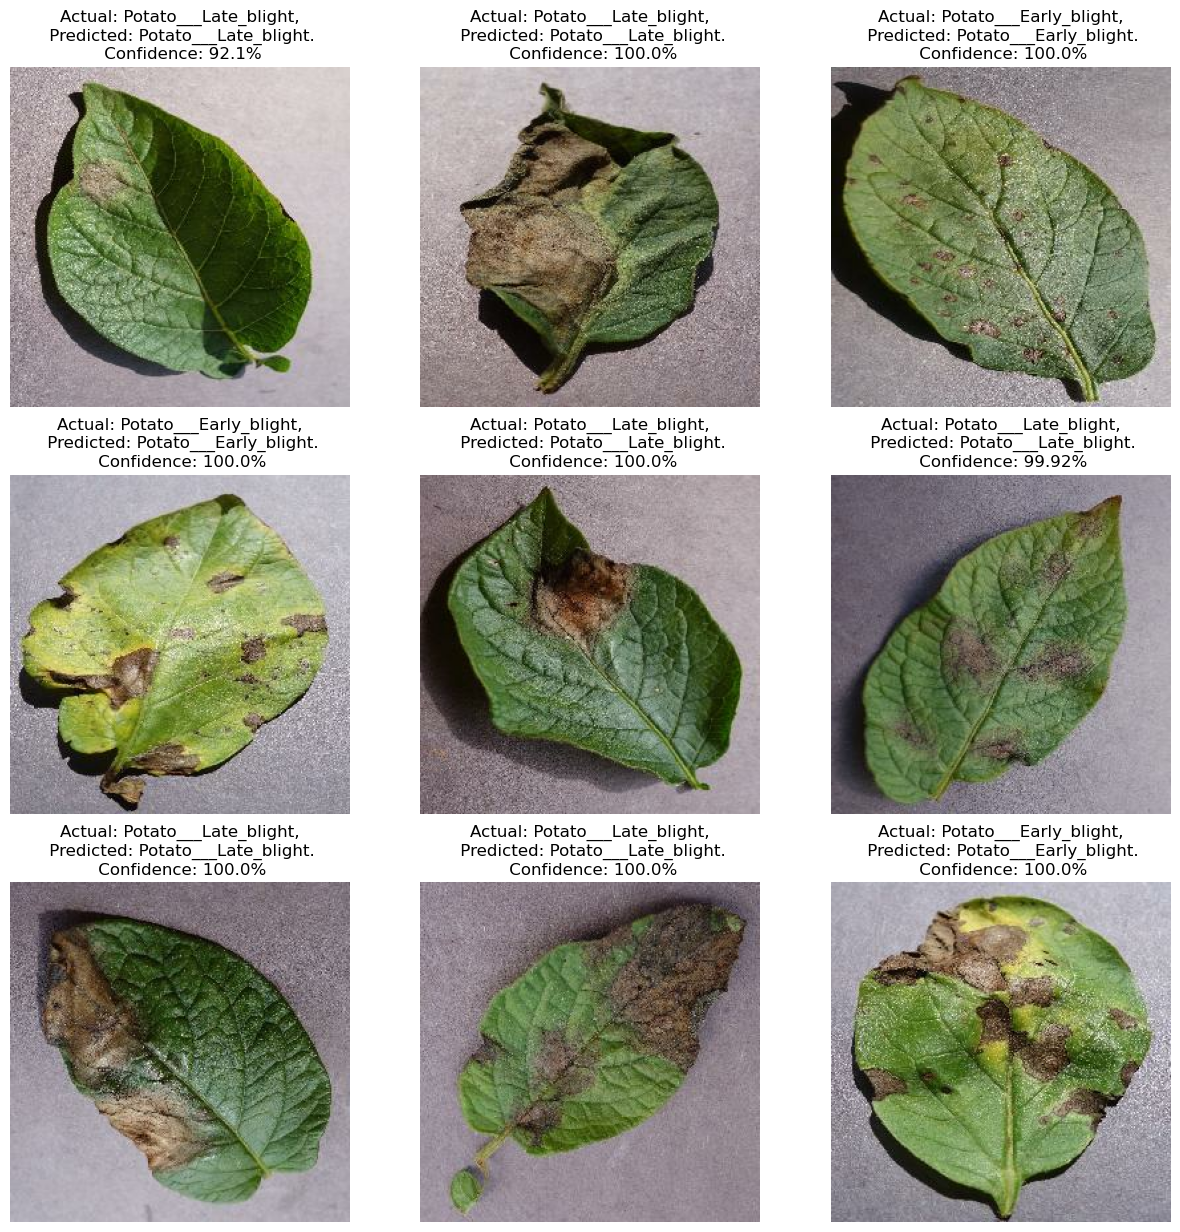

In [51]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis('off')

In [58]:
#model_version = 1
#model.save(f"../models/{model_version}")

#import os
#model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
#model.save(f"../models/{model_version}")

In [63]:
import os

# Create models directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

model_version = 1
model.save(f"../models/{model_version}.keras")

In [64]:
#[int(i) for i in os.listdir("../models")]